In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Slide:

    def __init__(self, center, width, length, orientation):
        self.center = center
        self.length = length
        self.width = width
        self.orientation = orientation

        # Calculate the corners of the slide
        self.corners = np.array([[self.center[0]-self.width/2, self.center[1]-self.length/2],
                                [self.center[0]+self.width/2, self.center[1]-self.length/2],
                                [self.center[0]+self.width/2, self.center[1]+self.length/2],
                                [self.center[0]-self.width/2, self.center[1]+self.length/2]])
        # Transform the corners according to the orientation
        theta = np.deg2rad(self.orientation)
        # Rotate corner about slide center
        T = np.array([[np.cos(theta), -np.sin(theta), self.center[0] - self.center[0]*np.cos(theta) + self.center[1]*np.sin(theta)],
                        [np.sin(theta), np.cos(theta), self.center[1] - self.center[0]*np.sin(theta) - self.center[1]*np.cos(theta)],
                        [0, 0, 1]])
        for i in range(len(self.corners)):
            self.corners[i] = np.matmul(T, np.append(self.corners[i], 1))[:2]

        # Calculate the corners of the slide
        self.bottom_left = self.corners[0]
        self.bottom_right = self.corners[1]
        self.top_right = self.corners[2]
        self.top_left = self.corners[3]

    # def contains(self, x, y):
    #     return self.point_in_triangle(x, y, self.bottom_left, self.bottom_right, self.top_right) or \
    #             self.point_in_triangle(x, y, self.bottom_left, self.top_right, self.top_left)

    # def point_in_triangle(self, x, y, p1, p2, p3):
    #     # Check if the point is within the triangle using barycentric coordinates
    #     s = (p1[1]*p3[0] - p1[0]*p3[1] + (p3[1] - p1[1])*x + (p1[0] - p3[0])*y) / \
    #         (p1[1]*p3[0] - p1[0]*p3[1] + p3[1]*p2[0] - p3[0]*p2[1] + p2[1]*p1[0] - p2[0]*p1[1])

    #     t = (p1[0]*p2[1] - p1[1]*p2[0] + (p1[1] - p2[1])*x + (p2[0] - p1[0])*y) / \
    #         (p1[1]*p3[0] - p1[0]*p3[1] + p3[1]*p2[0] - p3[0]*p2[1] + p2[1]*p1[0] - p2[0]*p1[1])

    #     return (s > 0) & (t > 0) & (1 - s - t > 0)

Area difference:  78461.27652340509
Rect area:  1875
Max rects:  42


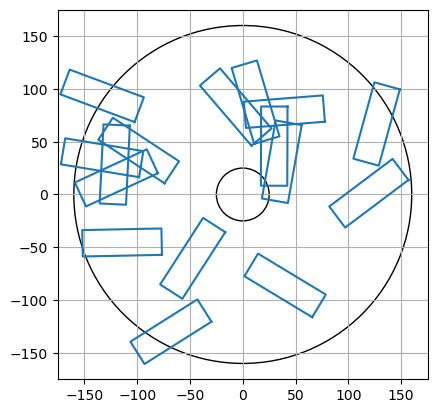

In [3]:
RADIUS_OUT = 160
RADIUS_IN = 25
SLIDE_WIDTH = 25
SLIDE_LENGTH = 75
SEP = 3

# Make circles
circle_out = plt.Circle((0, 0), RADIUS_OUT, edgecolor='black', facecolor='none')
circle_in = plt.Circle((0, 0), RADIUS_IN, edgecolor='black', facecolor='none')

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.add_artist(circle_out)
ax.add_artist(circle_in)
ax.set_xlim(-175, 175)
ax.set_ylim(-175, 175)
ax.grid(True)

# Area difference
area_diff = np.pi * (RADIUS_OUT**2 - RADIUS_IN**2)
print("Area difference: ", area_diff)
rect_area = SLIDE_WIDTH * SLIDE_LENGTH
print("Rect area: ", rect_area)
max_rects = area_diff / rect_area
print("Max rects: ", round(max_rects))

NUM_RECTS = 16
rect_centers = np.random.uniform(-RADIUS_OUT, RADIUS_OUT, size=(NUM_RECTS, 2))
rect_orientations = np.random.uniform(0, 179.9, size=NUM_RECTS)
rect_poses = np.hstack((rect_centers, rect_orientations.reshape(-1, 1)))
rects = []
for i in range(NUM_RECTS):
    rects.append(Slide(rect_poses[i][:2], SLIDE_WIDTH, SLIDE_LENGTH, rect_poses[i][2]))
    ax.plot(np.append(rects[i].corners[:, 0], rects[i].corners[0, 0]), np.append(rects[i].corners[:, 1], rects[i].corners[0, 1]), c='C0')

plt.show()

16
Overlap area:  1315.441576810587
OOB area:  7293.718965269938
Total area:  8609.160542080524


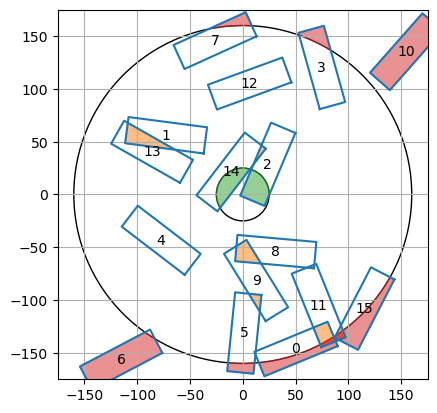

In [80]:
from shapely.geometry import Polygon, Point, MultiPolygon

# Perform gradient descent to minimise overlapping area
NUM_RECTS = 16
rect_centers = np.random.uniform(-RADIUS_OUT, RADIUS_OUT, size=(NUM_RECTS, 2))
rect_orientations = np.random.uniform(0, 179.9, size=NUM_RECTS)
rect_poses = np.hstack((rect_centers, rect_orientations.reshape(-1, 1)))

# Plot init
fig, ax = plt.subplots()
ax.set_aspect('equal')

ax.set_xlim(-175, 175)
ax.set_ylim(-175, 175)
ax.grid(True)

# Make circles
circle_out = plt.Circle((0, 0), RADIUS_OUT, edgecolor='black', facecolor='none')
circle_in = plt.Circle((0, 0), RADIUS_IN, edgecolor='black', facecolor='none')
ax.add_artist(circle_out)
ax.add_artist(circle_in)

def get_overlap_area(rects):
    # Calculate the area of overlap between all rectangles
    overlap_area = 0
    for i in range(len(rects)):
        for j in range(i+1, len(rects)):
            p1 = Polygon(rects[i].corners)
            p2 = Polygon(rects[j].corners)
            overlap = p1.intersection(p2)
            if overlap.area > 0:
                overlap_area += overlap.area
                ax.fill(*overlap.exterior.xy, c='C1', alpha=0.5)
    # Calculate the out of bounds area
    oob_area = 0
    for i in range(len(rects)):
        c1 = Point(0,0).buffer(RADIUS_IN)
        c2 = Point(0,0).buffer(RADIUS_OUT)
        p = Polygon(rects[i].corners)
        overlap1 = p.intersection(c1)
        overlap2 = p.difference(c2)
        if overlap1.area > 0:
            oob_area += overlap1.area
            ax.fill(*overlap1.exterior.xy, c='C2', alpha=0.5)
        if overlap2.area > 0:
            oob_area += overlap2.area
            ax.fill(*overlap2.exterior.xy, c='C3', alpha=0.5)

    return overlap_area, oob_area

rects = []
for i in range(NUM_RECTS):
    rects.append(Slide(rect_poses[i][:2], SLIDE_WIDTH, SLIDE_LENGTH, rect_poses[i][2]))
    ax.plot(np.append(rects[i].corners[:, 0], rects[i].corners[0, 0]), np.append(rects[i].corners[:, 1], rects[i].corners[0, 1]), c='C0')
    ax.annotate(i, (rects[i].center[0], rects[i].center[1]), ha='center', va='center')
print(len(rects))

overlap_area, oob_area = get_overlap_area(rects)
print("Overlap area: ", overlap_area)
print("OOB area: ", oob_area)
print("Total area: ", overlap_area + oob_area)

[[-10.22183463  14.27160513  61.26210726]
 [  0.89343487  34.74882366   3.23336785]]


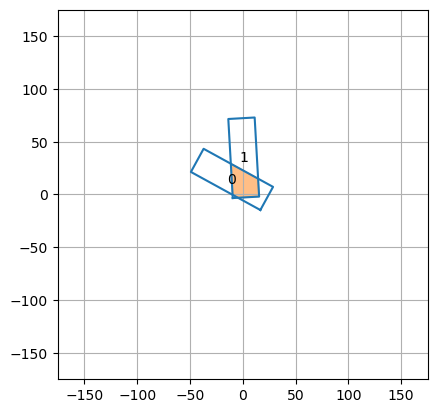

In [81]:
# Perform gradient descent to minimise overlapping area

# Plot init
fig, ax = plt.subplots()
ax.set_aspect('equal')

ax.set_xlim(-175, 175)
ax.set_ylim(-175, 175)
ax.grid(True)

NUM_ITER = 1
overlap_areas = []
for i in range(NUM_ITER):
    NUM_RECTS = 2
    rect_centers = np.random.uniform(-50, 50, size=(NUM_RECTS, 2))
    rect_orientations = np.random.uniform(0, 179.9, size=NUM_RECTS)
    rect_poses = np.hstack((rect_centers, rect_orientations.reshape(-1, 1)))
    print(rect_poses)

    rects = []
    for i in range(NUM_RECTS):
        rects.append(Slide(rect_poses[i][:2], SLIDE_WIDTH, SLIDE_LENGTH, rect_poses[i][2]))
        ax.plot(np.append(rects[i].corners[:, 0], rects[i].corners[0, 0]), np.append(rects[i].corners[:, 1], rects[i].corners[0, 1]), c='C0')
        ax.annotate(i, (rects[i].center[0], rects[i].center[1]), ha='center', va='center')

        overlap_area = 0
        for i in range(len(rects)):
            for j in range(i+1, len(rects)):
                p1 = Polygon(rects[i].corners)
                p2 = Polygon(rects[j].corners)
                overlap = p1.intersection(p2)
                if overlap.area > 0:
                    overlap_area += overlap.area
                    ax.fill(*overlap.exterior.xy, c='C1', alpha=0.5)
        overlap_areas.append(overlap_area)





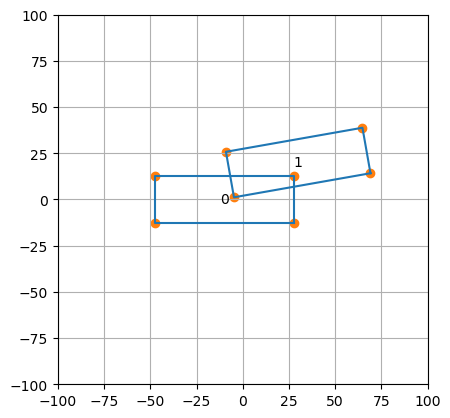

In [26]:
# Plot init
fig, ax = plt.subplots()
ax.set_aspect('equal')

ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.grid(True)

rect_poses = np.array([[-10, 0, 90], [30, 20, 100]])
rects = []
for i in range(len(rect_poses)):
    rects.append(Slide(rect_poses[i][:2], SLIDE_WIDTH, SLIDE_LENGTH, rect_poses[i][2]))
    ax.plot(np.append(rects[i].corners[:, 0], rects[i].corners[0, 0]), np.append(rects[i].corners[:, 1], rects[i].corners[0, 1]), c='C0')
    ax.annotate(i, (rects[i].center[0], rects[i].center[1]), ha='center', va='center')

# Plot vertices
for i in range(len(rects)):
    for j in range(len(rects[i].corners)):
        ax.scatter(rects[i].corners[j, 0], rects[i].corners[j, 1], c='C1')

# Returns the intersection point of two lines if they intersect, else None
def get_intersection(edge1, edge2):
    

# Find intersection points without Shapely
its_points = []
for i in range(4):
    edge1 = [rects[0].corners[i], rects[0].corners[(i+1)%4]]
    for j in range(4):
        edge2 = [rects[1].corners[j], rects[1].corners[(j+1)%4]]
        its_point = get_intersection(edge1, edge2)
        if its_point is not None:
            its_points.append(its_point)


In [35]:
def find_intersection(edge1, edge2):

    x1, y1 = edge1[0]
    x2, y2 = edge1[1]
    x3, y3 = edge2[0]
    x4, y4 = edge2[1]

    # Check if either edge is vertical
    if x2 == x1:  # Edge 1 is vertical
        m2 = (y4 - y3) / (x4 - x3)  # Calculate slope of edge 2

        intersection_x = x1
        intersection_y = m2 * (x1 - x3) + y3
    elif x4 == x3:  # Edge 2 is vertical
        m1 = (y2 - y1) / (x2 - x1)  # Calculate slope of edge 1

        intersection_x = x3
        intersection_y = m1 * (x3 - x1) + y1
    else:
        # Calculate the differences
        dx1 = x2 - x1
        dy1 = y2 - y1
        dx2 = x4 - x3
        dy2 = y4 - y3

        # Calculate the determinants
        det = dx1 * dy2 - dy1 * dx2

        # Check if the lines are parallel
        if det == 0:
            return None  # No intersection

        # Calculate the intersection point
        det_inv = 1 / det
        t1 = (x1 * y2 - y1 * x2) * det_inv
        t2 = (x3 * y4 - y3 * x4) * det_inv
        intersection_x = x1 + dx1 * t1
        intersection_y = y1 + dy1 * t1

    return intersection_x, intersection_y

edge1 = ((0, 0), (1, 1))
edge2 = ((0, 1), (1, 0))
intersection = find_intersection(edge1, edge2)
print(intersection)

(0.0, 0.0)


In [78]:
edge1 = [[0., 0.], [1., 1.]]
edge2 = [[0, 1.], [1., 0.]]

x1, y1 = edge1[0]
x2, y2 = edge1[1]
x3, y3 = edge2[0]
x4, y4 = edge2[1]

mat = tf.Variable([[y2-y1, x1-x2], [y4-y3, x3-x4]])
print(mat)
con = tf.Variable([[x1*y2-x2*y1], [x3*y4-x4*y3]])
print(con)

try:
    inv = tf.linalg.inv(mat)
except:
    print('singular matrix')
else:
    sol = tf.matmul(inv, con)
    print(sol)



<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 1., -1.],
       [-1., -1.]], dtype=float32)>
<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[ 0.],
       [-1.]], dtype=float32)>
tf.Tensor(
[[0.5]
 [0.5]], shape=(2, 1), dtype=float32)
tf.Tensor(0.5, shape=(), dtype=float32)


In [6]:
import tensorflow as tf

# Takes a N, 3 matrix of poses and returns the overlap area and out of bounds area
def get_overlap(x):
    rects = []
    for i in range(NUM_RECTS):
        rects.append(Slide(x[i][:2], SLIDE_WIDTH, SLIDE_LENGTH, x[i][2]))
    # Calculate the area of overlap between all rectangles
    overlap_area = 0
    for i in range(len(rects)):
        for j in range(i+1, len(rects)):
            p1 = Polygon(rects[i].corners)
            p2 = Polygon(rects[j].corners)
            overlap = p1.intersection(p2)
            if overlap.area > 0:
                overlap_area += overlap.area
    # Calculate the out of bounds area
    oob_area = 0
    for i in range(len(rects)):
        c1 = Point(0,0).buffer(RADIUS_IN)
        c2 = Point(0,0).buffer(RADIUS_OUT)
        p = Polygon(rects[i].corners)
        overlap1 = p.intersection(c1)
        overlap2 = p.difference(c2)
        if overlap1.area > 0:
            oob_area += overlap1.area
        if overlap2.area > 0:
            oob_area += overlap2.area
    overlap_area = tf.constant(overlap_area+oob_area)
    return overlap_area

num_rects = 16
pose_vars = tf.Variable(tf.random.uniform((num_rects, 3), minval=-160, maxval=160), dtype=tf.float32, trainable=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

num_iters = 1000
for i in range(num_iters):
    with tf.GradientTape() as tape:
        tape.watch(pose_vars)
        loss = get_overlap(pose_vars)
        grads = tape.gradient(loss, pose_vars)
    print(loss)
    print(grads)
    optimizer.apply_gradients(zip(grads, pose_vars))

    if i % 100 == 0:
        print("Iteration: ", i)
        print("Loss: ", loss.numpy())
        for j in range(num_rects):
            print("Rect ", j, ": ", pose_vars[j].numpy())
        print("Overlap area: ", overlap_area)
        print("OOB area: ", oob_area)
        print("Total area: ", overlap_area + oob_area)

optimized_poses = pose_vars.numpy()
print(f'Optimized poses: {optimized_poses}')

rects = []
for i in range(num_rects):
    rects.append(Slide(optimized_poses[i][:2], SLIDE_WIDTH, SLIDE_LENGTH, optimized_poses[i][2]))
    ax.plot(np.append(rects[i].corners[:, 0], rects[i].corners[0, 0]), np.append(rects[i].corners[:, 1], rects[i].corners[0, 1]), c='C0')
    ax.annotate(i, (rects[i].center[0], rects[i].center[1]), ha='center', va='center')

#### america explainnn

tf.Tensor(474.69836, shape=(), dtype=float32)
None


TypeError: 'NoneType' object is not iterable

tf.Tensor(46.673782, shape=(), dtype=float32)
tf.Tensor(
[[ 2.291588    0.2344456  -2.4458883 ]
 [-0.2093877   0.44883707  0.32508343]
 [ 2.158079    0.5823013   1.3693186 ]
 [ 0.22459209 -1.1027187   0.97080386]
 [-0.2934577   1.8451172  -1.3395065 ]
 [-2.0904613  -1.4276446  -0.06060576]
 [-4.0756845  -2.378584   -2.497206  ]
 [ 0.42196992 -0.54038864 -0.91706437]
 [ 1.2587729  -1.4176426   0.40893653]
 [ 1.4227794   0.13432139 -2.9733121 ]
 [ 2.2379937  -3.798797    1.0374228 ]
 [ 4.2003126   3.6321049   2.6428094 ]
 [-2.236518   -4.005215   -2.6543772 ]
 [ 0.76508373 -1.2541926   0.59267163]
 [ 0.10524348 -3.603052   -1.5901041 ]
 [-1.244493   -1.9337031   0.2730166 ]], shape=(16, 3), dtype=float32)
tf.Tensor(29.871223, shape=(), dtype=float32)
tf.Tensor(
[[ 1.8332704   0.18755648 -1.9567106 ]
 [-0.16751017  0.35906965  0.26006675]
 [ 1.7264631   0.46584105  1.0954549 ]
 [ 0.17967367 -0.88217497  0.7766431 ]
 [-0.23476616  1.4760938  -1.0716052 ]
 [-1.672369   -1.1421157  -0.048484

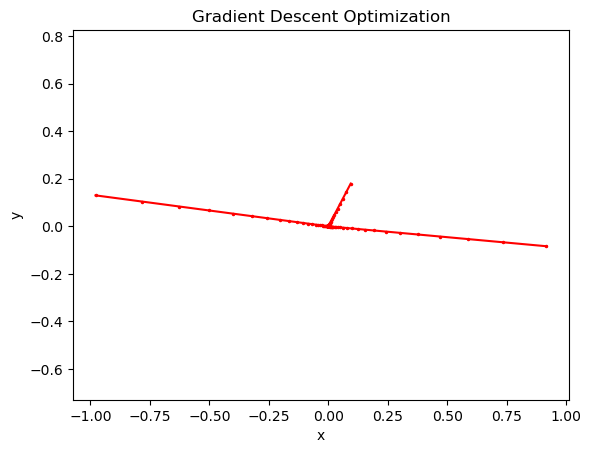

In [ ]:

# Define the function to be optimized
def function(x):
    return tf.reduce_sum(x**2)

# Define the learning rate and number of epochs
learning_rate = 0.1
epochs = 100

# Generate random initial values for the parameters
x = tf.Variable(np.random.randn(16, 3), dtype=tf.float32)

# Store the optimization path
path = []

# Perform gradient descent
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = function(x)
        print(loss)
    gradients = tape.gradient(loss, x)
    print(gradients)
    x.assign_sub(learning_rate * gradients)
    
    # Store the current values of x
    path.append(x.numpy())

# Convert the optimization path to numpy array
path = np.array(path)

# Plot the optimization path
plt.plot(path[:, 0], path[:, 1], 'r.-', markersize=3)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.title('Gradient Descent Optimization')
plt.show()
